<a href="https://colab.research.google.com/github/abhash896/Neural_network_training_on_GPU/blob/master/CNN/Image_classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification using convolution Neural Networks in PYTorch

Topics discussed in the notebook:


*   Understanding convolution and pooling layers
*   Creating a convolutional neural network(CNN) using PyTorch
*   Training a CNN from scratch and monitoring performance
*   Underfitting, overfitting and how to overcome them





We will be using the CIFAR10 Dataset for training the CNN.

This dataset consists of 60000 32x32 pixel color images divided into 10 classes.

In [48]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

We will download the images in PNG format, using some helper functions from the `torchvision` and `tarfile` packages.

In [49]:
# Download the dataset

dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(dataset_url, '.')

Using downloaded and verified file: ./cifar10.tgz


In [50]:
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path = './data')

In [51]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)

['train', 'test']
['cat', 'ship', 'dog', 'deer', 'horse', 'truck', 'frog', 'bird', 'airplane', 'automobile']


In [52]:
airplane_files= os.listdir(data_dir + '/train/airplane')
print('No. of training examples for airplanes: ', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes:  5000
['2047.png', '2078.png', '3473.png', '2979.png', '3039.png']


In [53]:
bird_files=os.listdir(data_dir + '/train/bird')
print('No. of training examples for bird: ', len(bird_files))
print(bird_files[:5])

No. of training examples for bird:  5000
['2047.png', '2078.png', '3473.png', '2979.png', '3039.png']


The above directory structure (one folder per class) is used by many computer vision datasets, and most deep learning libraries provide utilites for working with such datasets. We can use the `ImageFolder` class from `torchvision` to load the data as PyTorch tensors.

In [54]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [55]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

In [56]:
img, label = dataset[6000]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 1


tensor([[[0.7216, 0.7294, 0.7647,  ..., 0.6078, 0.7216, 0.5608],
         [0.5529, 0.5412, 0.5490,  ..., 0.3608, 0.4549, 0.3059],
         [0.5216, 0.5412, 0.5843,  ..., 0.3451, 0.3333, 0.2824],
         ...,
         [0.6667, 0.6824, 0.6980,  ..., 0.7451, 0.7294, 0.7098],
         [0.6431, 0.6706, 0.6941,  ..., 0.7255, 0.7020, 0.6824],
         [0.6275, 0.6627, 0.6863,  ..., 0.7255, 0.6941, 0.6627]],

        [[0.7490, 0.7569, 0.7922,  ..., 0.6549, 0.7686, 0.6118],
         [0.5882, 0.5765, 0.5843,  ..., 0.4353, 0.5333, 0.3961],
         [0.5490, 0.5725, 0.6157,  ..., 0.4314, 0.4275, 0.3882],
         ...,
         [0.6471, 0.6510, 0.6588,  ..., 0.7216, 0.7059, 0.6824],
         [0.6235, 0.6392, 0.6549,  ..., 0.7020, 0.6784, 0.6588],
         [0.6039, 0.6275, 0.6471,  ..., 0.7020, 0.6706, 0.6392]],

        [[0.7686, 0.7765, 0.8118,  ..., 0.6431, 0.7529, 0.5647],
         [0.6118, 0.6039, 0.6118,  ..., 0.3922, 0.4588, 0.2627],
         [0.5373, 0.5608, 0.6039,  ..., 0.3804, 0.3373, 0.

In [57]:
for i, j in enumerate(dataset.classes):
  print(i, j)

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

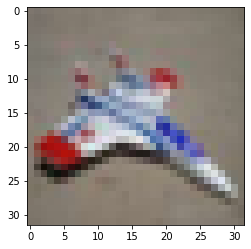

In [59]:
image, label = dataset[1]
plt.imshow(image.permute((1,2,0)))

Let's write a function to show the example image:

In [60]:
def show_image(img, label):
  print('Label: ', dataset.classes[label])
  plt.imshow(img.permute((1, 2, 0)))

Label:  airplane


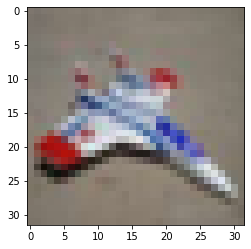

In [61]:
show_image(*dataset[1])

# Training and validation Datasets

Since there is no predefined validation set, we can set aside a small portion (5000 images) of the training set to be used as the validation set. We will use the `random_split` helper method from PyTorch to do this. To ensure that we always create the same validation set, we will also set a seet for the random generator.

In [62]:
random_seed = 52
torch.manual_seed(random_seed); # applying ; at the end of the line ensures that there is no output display

In [63]:
val_size=5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

We can now create data loaders for training and validation, to load the data in batches

In [64]:
from torch.utils.data.dataloader import DataLoader

In [65]:
batch_size=128

In [66]:
train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers = 2, 
                      pin_memory = True)
val_dl = DataLoader(val_ds, 
                    batch_size*2, # We will double the batch size for validation set as we are not going to compute gradients for validation set. So, we will only need half of the memory.
                    num_workers = 2, 
                    pin_memory = True) 

We can look at batches of images from the datasest using the `make_grid` method from torchvision. Each time the following code is run, we get a differenct batch, since the sampler shuffles the indices before creating batches.

In [67]:
from torchvision.utils import make_grid

In [68]:
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(18, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

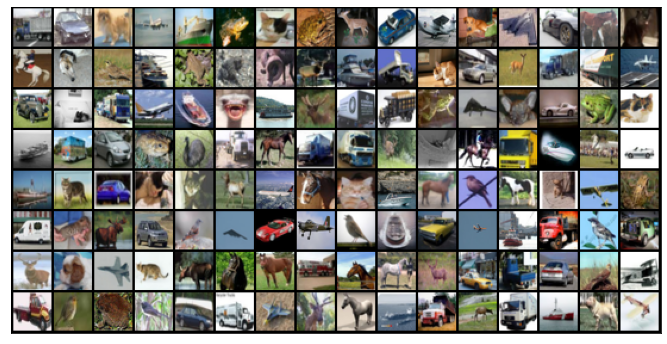

In [69]:
show_batch(train_dl)

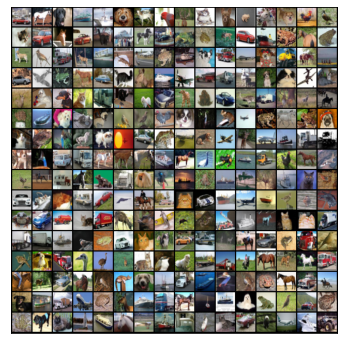

In [70]:
show_batch(val_dl)

# Defining the Model (Convolutional Neural Network)

A deep neural network with fully-connected layers can be defined using `nn.Linear` class. We can use a convolutional neural network using the `nn.Conv2d` class from PyTorch.

Let us implement a convolution operation on an image with one color channel and convolve it with a 3x3 kernel.

In [71]:
def apply_kernel(image, kernel):
  row_i, col_i = image.shape        # image dimensions
  row_k, col_k = kernel.shape       # kernel dimensions
  row_o, col_o = row_i - row_k + 1, col_i - col_k + 1        # output dimensions, formula for output dim = ((n+2p-f)/s)+1   where n=image size, p=padding, f=filter, s=stride
  output = torch.zeros([row_o, col_o])
  for i in range(row_o):
    for j in range(col_o):
      output[i, j] = torch.sum(image[i:i+row_k, j: j+col_k] * kernel)

  return output


In [72]:
sample_image =torch.tensor([
    [3, 3, 2, 1, 0],
    [0, 0, 1, 3, 1], 
    [3, 1, 2 ,2 ,3],
    [2, 0, 0, 2, 2],
    [2, 0, 0, 0, 1]
], dtype = torch.float32)
sample_kernel = torch.tensor([
    [0, 1, 2],
    [2, 2, 0],
    [0, 1, 2]
], dtype = torch.float32)

apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

There are certain advantages offered by convolutional layers when working with image data:

Fewer parameters: A small set of parameters (the kernel) is used to calculated 
outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer.

Sparsity of connections: In each layer, each output element only depends on a samll number of input elements, which makes the forward and backward passes more efficient.

Parameter sharing and spatial invariance: The features learned by a kernel in one part of the image can be used to detect similar pattern in a different part of another image.

We will also use a max-pooling layer to progressively decrease the height and width of the output tensors from each convolutional layer.

In [73]:
import torch.nn as nn
import torch.nn.functional as F

In [74]:
# Creating single conv layer and pool layer to see how they work
conv=nn.Conv2d(3,8, kernel_size = 3, stride=1, padding=1)
pool=nn.MaxPool2d(2,2)

In [75]:
for images, labels in train_dl:
  print('images.shape: ', images.shape)
  out = conv(images)
  print('out.shape', out.shape)
  out = pool(out)
  print('out.shape', out.shape)
  break

images.shape:  torch.Size([128, 3, 32, 32])
out.shape torch.Size([128, 8, 32, 32])
out.shape torch.Size([128, 8, 16, 16])


In [76]:
simple_model = nn.Sequential(
    nn.Conv2d(3,8, kernel_size = 3, stride=1, padding=1),
    nn.MaxPool2d(2,2)
)

In [77]:
for images, labels in train_dl:
  print('images.shape: ', images.shape)
  out = simple_model(images)
  print('out.shape', out.shape)
  break

images.shape:  torch.Size([128, 3, 32, 32])
out.shape torch.Size([128, 8, 16, 16])


Let's define the model by extending an `ImageClassificationBase` class which will be a child class of the `nn.Module` class and which contains helper methods for training and validation.

In [78]:
class ImageClassificationBase(nn.Module):

  def training_step(self, batch):
    """Returns the loss for a batch of training data"""
    images, labels = batch
    out = self(images)                      # Generate predictions
    loss = F.cross_entropy(out, labels)     # Calculate loss
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)                      # Generate predictions
    loss = F.cross_entropy(out, labels)     # calculate loss
    acc = accuracy(out, labels)             # calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()       # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()          # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print(f'Epoch [{epoch}], val_loss: {result["val_loss"]}, val_acc: {result["val_acc"]}')


def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim = 1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

We will use `nn.Sequential` to chain the layers and activation functions into a single network architecture.

In [79]:
class Cifar10CnnModel(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        # Block 1
        # input: 3 x 32 x 32
        nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),    # Output: 64 x 16 x 16

        # Block 2
        nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),    # Output: 128 x 8 x 8

        # Block 3
        nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),    # Output: 256 x 4 x 4

        nn.Flatten(),    # It is not a layer as it does not have weights and biases. It takes the output feature map and flatten it out into a vector.
        nn.Linear(256*4*4, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )

  def forward(self, xb):
    return self.network(xb)

In [80]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

Let's verify that the model produces the expected output on a batch of training data. The 10 outputs for each image can be interpreted as probabilites for the 10 target classes (after applying softmax), and the class with the highest probability is chosen as the label predicted by the model for the input image.

In [81]:
for images, labels in train_dl:
  print('images.shape: ', images.shape)
  out = model(images)
  print('out.shape: ', out.shape)
  print('out[0]: ', out[0])
  break

images.shape:  torch.Size([128, 3, 32, 32])
out.shape:  torch.Size([128, 10])
out[0]:  tensor([ 0.0256,  0.0204,  0.0262,  0.0351,  0.0036, -0.0486,  0.0173,  0.0210,
        -0.0248, -0.0237], grad_fn=<SelectBackward0>)


To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` and `to_device`) and a helper class `DeviceDataLoader` to move our model and data to the GPU as required. 

In [82]:
def get_default_device():
  '''Pick GPU if avaialble, else CPU'''
  if torch.cuda.is_available():
    return torch.device('cuda')

  else:
    return torch.device('cpu')

def to_device(data, device):
  '''Move tensor(s) to chosen device'''
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

In [83]:
class DeviceDataLoader():
  '''Wrap a data_loader to move data to a device'''
  def __init__(self, data_loader, device):
    self.data_loader = data_loader
    self.device = device

  def __iter__(self):
    '''Yield a batch of data after moving it to a device'''
    for b in self.data_loader:
      yield to_device(b, self.device)

  def __len__(self):
    '''Number of batches'''
    return len(self.data_loader)

In [84]:
device = get_default_device()
device

device(type='cuda')

Now we can wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available), and use `to_device` to move our model to the GPU (if available).

In [85]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

# Training the Model

We will define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set.


When introducing new layers like ReLU, MaxPool etc, these layers behave differently when the model is being trained and when the model is being evaluated. so, to configure this behaviour, we need to inform PyTorch when we are training and when we are evaluating.

We add a decorator `torch.no_grad` with `evaluate` function. It tells pytorch, while the evaluate function is being executed, we do not want to compute any gradients because we are not performing gradient descent.

In [86]:
@torch.no_grad()
def evaluate(model, val_loader):
  '''Evaluate the model's performance on the validation set.'''
  model.eval()    # It tells pytorch that the layers should be put in evaluation mode. There is no randomization in evaluation.
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)


# Defining a function to train the model.

def fit(epochs, lr, model, train_loader, val_loader, opt_funct = torch.optim.SGD):
  '''Train the model using gradient descent.'''

  optimizer = opt_funct(model.parameters(), lr)
  log = []

  for epoch in range(epochs):
    # Training phase
    model.train()    # It tells pytorch that we are training the model. There is randomization in training.
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch) # yet to define the training_step function.
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # validation phase
    result = evaluate(model, val_loader) # not yet defined.
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    log.append(result)

  return log



In [87]:
model = to_device(Cifar10CnnModel(), device)

In [88]:
evaluate(model, val_dl)

{'val_loss': 2.3021717071533203, 'val_acc': 0.11252298206090927}

In [89]:
num_epochs = 30
opt_funct = torch.optim.Adam
lr = 0.001

In [90]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_funct)

Epoch [0], val_loss: 1.4288474321365356, val_acc: 0.47010570764541626
Epoch [1], val_loss: 1.2290781736373901, val_acc: 0.5536879301071167
Epoch [2], val_loss: 1.0206953287124634, val_acc: 0.636833667755127
Epoch [3], val_loss: 0.8542772531509399, val_acc: 0.7018038034439087
Epoch [4], val_loss: 0.8000661730766296, val_acc: 0.7205767631530762
Epoch [5], val_loss: 0.7400606274604797, val_acc: 0.7414522171020508
Epoch [6], val_loss: 0.7747567892074585, val_acc: 0.7350069284439087
Epoch [7], val_loss: 0.724007785320282, val_acc: 0.7591911554336548
Epoch [8], val_loss: 0.7485252618789673, val_acc: 0.7588924169540405
Epoch [9], val_loss: 0.841382622718811, val_acc: 0.7457031011581421
Epoch [10], val_loss: 0.8153733611106873, val_acc: 0.771484375
Epoch [11], val_loss: 0.9866709113121033, val_acc: 0.7465533018112183
Epoch [12], val_loss: 0.9960047602653503, val_acc: 0.7695082426071167
Epoch [13], val_loss: 1.1115626096725464, val_acc: 0.7584444284439087
Epoch [14], val_loss: 1.147600054740905

We can plot the validation set accuracies to study how the model improves over time.

In [95]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs No. of epochs');
  


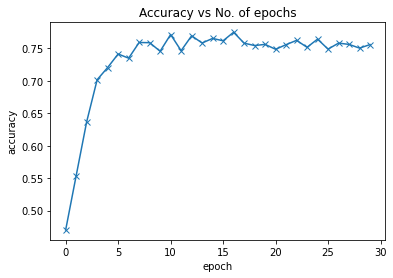

In [96]:
plot_accuracies(history)

In [97]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('Loss')
  plt.legend(['Training', 'validation'])
  plt.title('Loss vs No. of epochs')


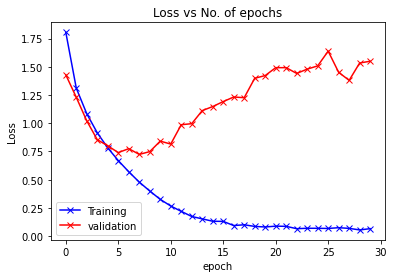

In [98]:
plot_losses(history)

# Testing with Individual images

We begin by creating a test dataset using the `ImageFolder` class.

In [99]:
test_dataset = ImageFolder(data_dir+'/test', transform = ToTensor())

Let's define a helper function `predict_image` which returns the predicted label for a single image tensor.

In [107]:
def predict_image(img, model):
  # Convert to a batch of 1
  xb = to_device(img.unsqueeze(0), device)
  # Get predictions from model
  yb = model(xb)
  # Pick index with highest probability
  _, preds = torch.max(yb, dim = 1)
  # Retrieve the class label
  return dataset.classes[preds[0].item()]

Label:  dog , Predicted:  dog


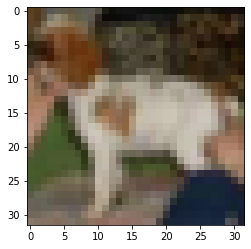

In [109]:
img, label = test_dataset[5000]
plt.imshow(img.permute(1, 2, 0))
print('Label: ', dataset.classes[label], ', Predicted: ', predict_image(img, model))

In [106]:
predict_image(test_dataset[5000][0], model)

5

In [110]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result


{'val_loss': 1.5221887826919556, 'val_acc': 0.761523425579071}

# Saving and loading the model

In [111]:
torch.save(model.state_dict(), 'CIFAR10-CNN.pth')

In [112]:
model2 = to_device(Cifar10CnnModel(), device)

In [113]:
model2.load_state_dict(torch.load('CIFAR10-CNN.pth'))

<All keys matched successfully>

In [114]:
evaluate(model2, test_loader)

{'val_loss': 1.5221887826919556, 'val_acc': 0.761523425579071}